In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import time
import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge, BayesianRidge
import lightgbm as lgb
import gc
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
train_df = pd.read_csv('../data/train.csv', parse_dates=["first_active_month"])
test_df = pd.read_csv('../data/test.csv', parse_dates=["first_active_month"])

print("Training data size",train_df.shape)
print("Testing data size",test_df.shape)

Training data size (201917, 6)
Testing data size (123623, 5)


In [3]:
train_df['elasped_time'] = (datetime.date(2018, 2, 1) - train_df['first_active_month'].dt.date).dt.days
test_df['elasped_time'] = (datetime.date(2018, 2, 1) - test_df['first_active_month'].dt.date).dt.days

train_df["year"] = train_df["first_active_month"].dt.year
test_df["year"] = test_df["first_active_month"].dt.year
train_df["month"] = train_df["first_active_month"].dt.month
test_df["month"] = test_df["first_active_month"].dt.month
test_df['is_month_start'] = test_df['first_active_month'].dt.is_month_start
train_df['is_month_start'] = train_df['first_active_month'].dt.is_month_start

train_df['outliers'] = 0
train_df.loc[train_df['target']<-30,'outliers']=1
train_df['outliers'].value_counts()

target = train_df['target']
target_o = train_df.loc[train_df['target']<-30,'target']
target_no = train_df.loc[train_df['target']>=-30,'target']
del train_df['target']
gc.collect()

39

In [ ]:
target_o.describe()

In [5]:
hist_df = pd.read_csv('../data/historical_transactions.csv')
new_df = pd.read_csv("../data/new_merchant_transactions.csv")

print("Historical transactions data size",hist_df.shape)
print("New transactions data size",new_df.shape)

Historical transactions data size (29112361, 14)
New transactions data size (1963031, 14)


In [ ]:
hd = {'Unique Entry': hist_df.nunique(axis = 0), 'Nan Entry': hist_df.isnull().any()}
pd.DataFrame(data = hd, index = hist_df.columns.values)

In [6]:
new_df.installments.value_counts()

 0      922244
 1      836178
-1       55922
 2       54729
 3       44750
 4       14815
 6       10389
 5        9296
 10       8899
 12       2850
 8        1555
 7         863
 9         478
 11         61
 999         2
Name: installments, dtype: int64

In [7]:
mask = (hist_df.installments == 999)
hist_df.loc[mask,'installments'].replace(999,-1,inplace=True)

mask = (new_df.installments == 999)
new_df.loc[mask,'installments'].replace(999,-1,inplace=True)

In [8]:
for df in [hist_df,new_df]:
#    df['category_2'].fillna(1.0,inplace=True)
#    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [9]:
#for df in [hist_df,new_df]:
#    df['category_2'].fillna(1.0,inplace=True)
#    df['category_3'].fillna('A',inplace=True)
#    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
for df in [hist_df,new_df]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['weekday'] = (df.purchase_date.dt.weekday <5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [10]:
hist_df = pd.get_dummies(hist_df,columns=['category_2','category_3'])
new_df = pd.get_dummies(new_df,columns=['category_2','category_3'])

agg_fun = {'authorized_flag': ['mean']}
auth_mean = hist_df.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

auth_df = hist_df[hist_df['authorized_flag'] == 1]
hist_df = hist_df[hist_df['authorized_flag'] == 0]

In [11]:
def aggregate_historical_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id':['nunique'],
        'state_id':['nunique'],
        'city_id': ['nunique'],
        'subsector_id':['nunique'],
        'year':['nunique'],
        'month':['nunique'],
        'weekofyear':['nunique'],        
        'weekend':['sum','mean'],
        'weekday':['sum','mean'],
        # non-categorical features
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'purchase_date': [np.ptp,'min','max'],
        'month_lag': ['min', 'max','mean','std'],
        'month_diff':['mean'],
        'authorized_flag': ['sum', 'mean'],
        }
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() 
                           for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='hist_transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [12]:
history = aggregate_historical_transactions(hist_df)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,...,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_min,hist_month_lag_max,hist_month_lag_mean,hist_month_lag_std,hist_month_diff_mean,hist_authorized_flag_sum,hist_authorized_flag_mean
0,C_ID_00007093c1,35,4,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,...,28858113.0,1.489250e+09,1.518108e+09,-11,0,-6.028571,3.535415,10.857143,0,0
1,C_ID_0001238066,3,0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,...,3609150.0,1.514660e+09,1.518269e+09,-2,0,-1.333333,1.154701,10.333333,0,0
2,C_ID_0001506ef0,4,0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,...,22098875.0,1.496772e+09,1.518871e+09,-8,0,-2.500000,3.785939,11.000000,0,0
3,C_ID_0001793786,27,2,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,...,16780236.0,1.488636e+09,1.505416e+09,-7,-1,-3.518519,2.375684,14.888889,0,0
4,C_ID_000183fdda,7,0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,...,6701589.0,1.502099e+09,1.508801e+09,-6,-4,-5.714286,0.755929,10.571429,0,0


In [13]:
history.hist_installments_sum.value_counts()

0       69652
1       36962
2       26236
3       18462
4       14298
5       10645
6        9696
7        7315
8        6422
10       5590
9        5303
12       4639
11       4357
13       3607
14       3193
15       2965
16       2752
17       2327
20       2238
18       2156
19       1913
21       1853
22       1704
24       1644
23       1469
25       1340
26       1229
27       1121
28       1110
30       1090
        ...  
613         1
464         1
1576        1
552         1
466         1
295         1
294         1
448         1
701         1
1091        1
425         1
668         1
1184        1
421         1
1088        1
320         1
423         1
319         1
424         1
685         1
311         1
431         1
316         1
1462        1
1083        1
695         1
313         1
312         1
443         1
627         1
Name: hist_installments_sum, Length: 463, dtype: int64

In [14]:
to_drop = ['hist_authorized_flag_mean','hist_authorized_flag_sum']
history.drop(labels=to_drop ,axis = 1,inplace = True)

In [15]:
authorized = aggregate_historical_transactions(auth_df)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_hist_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,...,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_min,auth_month_lag_max,auth_month_lag_mean,auth_month_lag_std,auth_month_diff_mean,auth_authorized_flag_sum,auth_authorized_flag_mean
0,C_ID_00007093c1,114,24,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,...,32627654.0,1.487081e+09,1.519708e+09,-12,0,-5.798246,3.441495,10.807018,114,1
1,C_ID_0001238066,120,2,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,...,13110825.0,1.506638e+09,1.519748e+09,-5,0,-1.825000,1.294218,10.675000,120,1
2,C_ID_0001506ef0,62,0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,...,34460275.0,1.484411e+09,1.518871e+09,-13,0,-4.983871,4.248402,10.887097,62,1
3,C_ID_0001793786,189,0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,...,24487497.0,1.484994e+09,1.509481e+09,-9,0,-3.301587,2.301491,14.873016,189,1
4,C_ID_000183fdda,137,4,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,...,15148616.0,1.504444e+09,1.519592e+09,-5,0,-2.284672,1.782055,10.810219,137,1


In [16]:
authorized.auth_authorized_flag_sum.value_counts()

14      4996
11      4904
13      4778
12      4765
15      4663
16      4625
9       4553
10      4540
17      4505
18      4484
19      4407
20      4374
21      4293
22      4254
8       4182
23      4031
7       3971
25      3958
24      3857
26      3850
27      3743
29      3735
28      3698
31      3522
30      3515
6       3389
32      3354
33      3288
36      3197
35      3180
        ... 
1157       1
963        1
708        1
964        1
1125       1
709        1
1464       1
873        1
875        1
1074       1
1138       1
1195       1
1053       1
1963       1
882        1
941        1
881        1
944        1
945        1
1201       1
1051       1
880        1
946        1
1202       1
947        1
879        1
1204       1
1460       1
949        1
1045       1
Name: auth_authorized_flag_sum, Length: 1061, dtype: int64

In [17]:
to_drop = ['auth_authorized_flag_mean','auth_authorized_flag_sum']
authorized.drop(labels=to_drop ,axis = 1,inplace = True)

In [18]:
new = aggregate_historical_transactions(new_df)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_hist_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,...,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_min,new_month_lag_max,new_month_lag_mean,new_month_lag_std,new_month_diff_mean,new_authorized_flag_sum,new_authorized_flag_mean
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,...,537024.0,1.522754e+09,1.523291e+09,2,2,2.000000,0.000000,11.000000,2,1
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,...,5195343.0,1.519923e+09,1.525118e+09,1,2,1.346154,0.485165,10.576923,26,1
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,...,471152.0,1.521239e+09,1.521710e+09,1,1,1.000000,0.000000,11.000000,2,1
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,...,3981096.0,1.510761e+09,1.514742e+09,1,2,1.322581,0.475191,14.322581,31,1
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,...,5106807.0,1.519994e+09,1.525100e+09,1,2,1.272727,0.467099,10.727273,11,1


In [19]:
new.new_authorized_flag_mean.value_counts()

1    290001
Name: new_authorized_flag_mean, dtype: int64

In [20]:
new.new_installments_max.value_counts()

 0      137170
 1       69341
 3       22880
 2       21305
 4        9573
 6        7898
 10       7878
 5        6476
 12       2772
-1        2229
 8        1292
 7         727
 9         399
 11         59
 999         2
Name: new_installments_max, dtype: int64

In [21]:
to_drop = ['new_authorized_flag_mean','new_authorized_flag_sum']
new.drop(labels=to_drop ,axis = 1,inplace = True)

In [22]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(auth_df) 
final_group[:10]


,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.803314,2.175011,-0.536131,0.075418,-0.702649,...,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.776212,6.676914,-0.603215,0.046045,-0.730351,...,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.438161,2.902501,-0.446660,0.271125,-0.725724,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496067,4.018810,-0.005687,0.271221,-0.646277,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.316093,4.800612,-0.489227,0.141015,-0.728405,...,40.833333,14.048725,1.834943,0.362557,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529
5,C_ID_00024e244b,-6.384615,4.330867,4.076923,4.290717,-2.557396,2.089708,-0.685118,0.071894,-0.728885,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,C_ID_0002709b5a,-5.000000,3.316625,6.090909,3.505839,-3.994622,2.440540,-0.638637,0.060836,-0.700104,...,10.727273,8.427229,1.965729,1.287108,0.818182,0.603023,3.818182,3.341203,1.600058,1.734256
7,C_ID_00027503e2,-4.000000,2.738613,2.666667,1.224745,-1.974976,0.909525,-0.740077,0.002424,-0.742206,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-5.250000,4.334249,3.500000,1.772811,-1.844563,0.699127,-0.590214,0.168008,-0.686623,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,C_ID_0002ba3c2e,-4.666667,3.141125,9.166667,4.665476,-5.843052,3.021165,-0.638037,0.044976,-0.721448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [24]:
additional_fields = successive_aggregates(new_df, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_df, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_df, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_df, 'category_1', 'installments'),
                                            on = 'card_id', how='left')
del new_df
del auth_df
del hist_df

In [25]:
train_df = pd.merge(train_df, history, on='card_id', how='left')
test_df = pd.merge(test_df, history, on='card_id', how='left')

train_df = pd.merge(train_df, authorized, on='card_id', how='left')
test_df = pd.merge(test_df, authorized, on='card_id', how='left')

train_df = pd.merge(train_df, new, on='card_id', how='left')
test_df = pd.merge(test_df, new, on='card_id', how='left')

In [26]:
train_df = pd.merge(train_df, final_group, on='card_id', how='left')
test_df = pd.merge(test_df, final_group, on='card_id', how='left')

train_df = pd.merge(train_df, additional_fields, on='card_id', how='left')
test_df = pd.merge(test_df, additional_fields, on='card_id', how='left')

In [27]:
train_df = pd.merge(train_df, auth_mean, on='card_id', how='left')
test_df = pd.merge(test_df, auth_mean, on='card_id', how='left')

In [28]:
for df in [train_df, test_df]:
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['hist_first_buy'] = (df['hist_purchase_date_min'].values.astype('datetime64[s]') - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'].values.astype('datetime64[s]') - df['first_active_month']).dt.days
    df['new_first_buy'] = (df['new_purchase_date_min'].values.astype('datetime64[s]') - df['first_active_month']).dt.days
    df['new_last_buy'] = (df['new_purchase_date_max'].values.astype('datetime64[s]') - df['first_active_month']).dt.days

In [29]:
train_df.shape

(201917, 181)

In [30]:
test_df.shape

(123623, 180)

In [ ]:
train_df['hist_first_buy'].describe()

In [ ]:
#del train_df['outliers']
# train_df = train_df[train_df['outliers'] == 0]

In [ ]:
# train_df['target'] = target

In [31]:
test_df.to_csv('../data_feat/test_v6_fill.csv', index=False)
train_df.to_csv('../data_feat/train_v6_fill.csv', index=False)

In [32]:
#features = [c for c in train_df.columns if c not in ['card_id', 'first_active_month']]
features = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','outliers']]
#features = [f for f in features if f not in unimportant_features]
categorical_feats = ['feature_1','feature_2', 'feature_3','year','month']

In [ ]:
target = train_df["outliers"]

In [33]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "nthread": -1,
         "verbosity": -1}

In [43]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [45]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, 
                    early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1382]	training's rmse: 0.0925476	valid_1's rmse: 0.100387
fold n°1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[924]	training's rmse: 0.0945686	valid_1's rmse: 0.0981306
fold n°2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1030]	training's rmse: 0.0943011	valid_1's rmse: 0.0972726
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1185]	training's rmse: 0.0922621	valid_1's rmse: 0.103218
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[707]	training's rmse: 0.0954553	valid_1's rmse: 0.0979537
CV score: 0.09942 


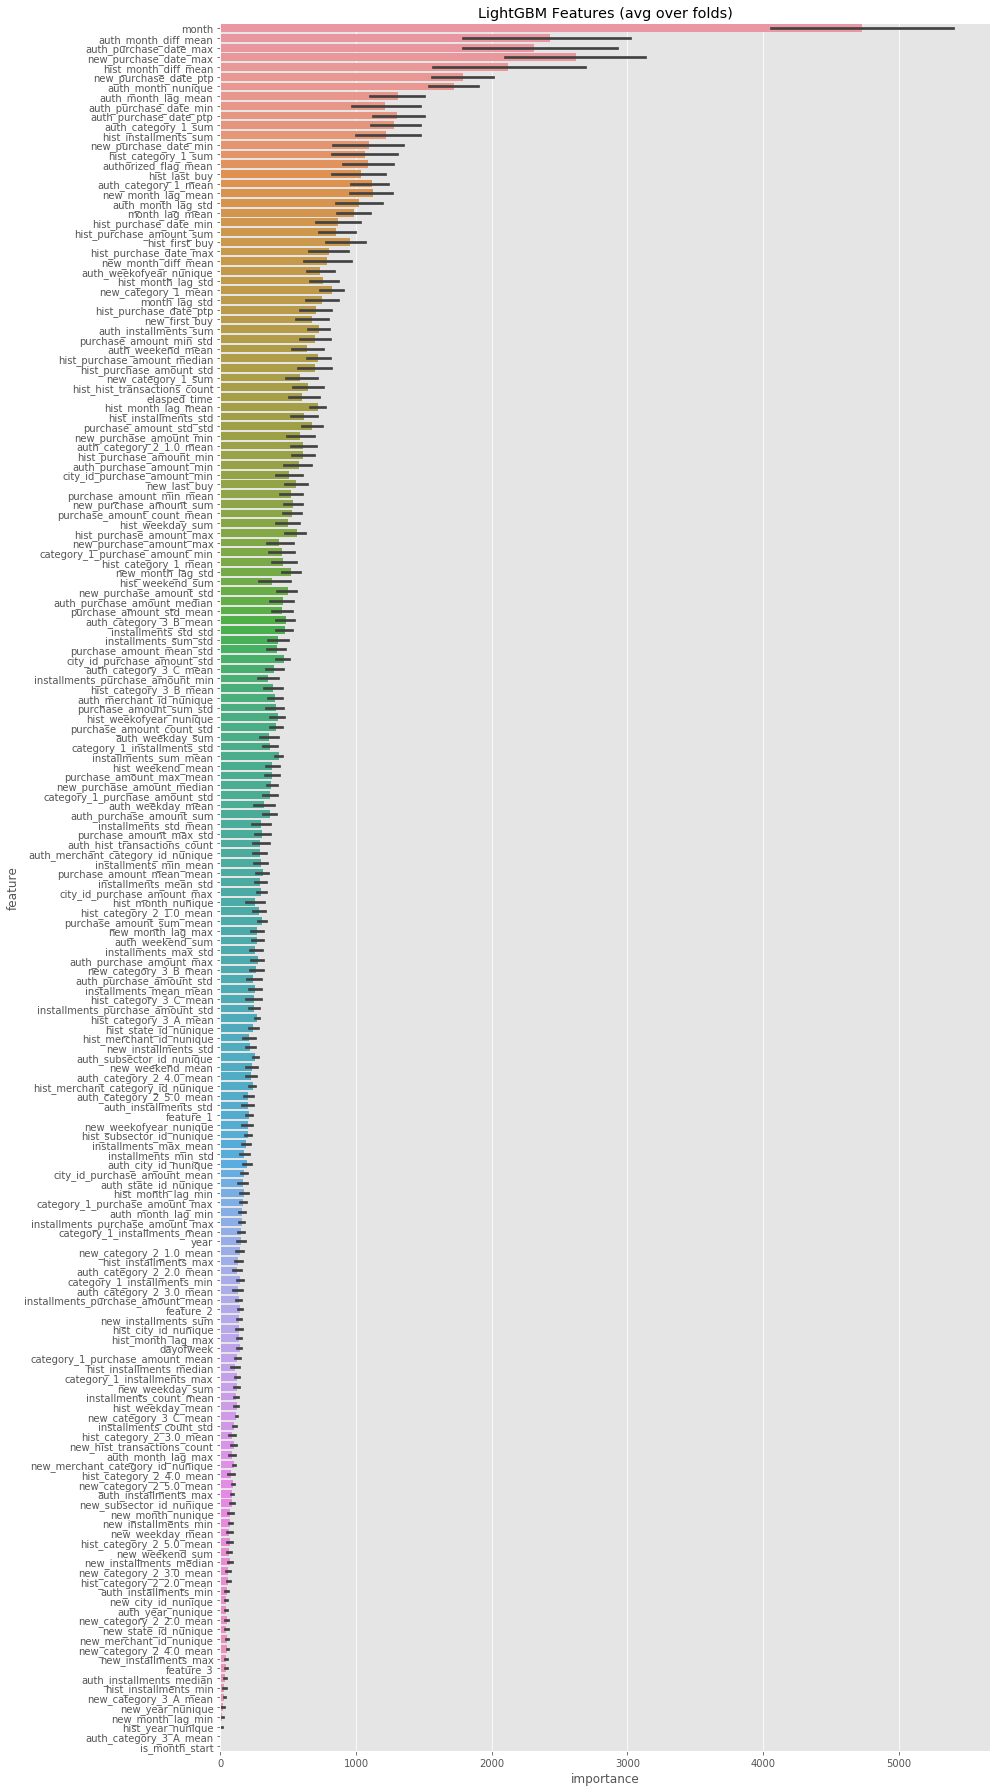

In [46]:
plt.style.use('ggplot')
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('../fig/lgbm_importances_v5_2.png')
plt.show()

In [47]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("../submission/submit_v4_strat2.csv", index=False)